### 处理数据

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 读取数据
train = pd.read_csv('D:/上学资料/研二上/train.csv', index_col='id')
test = pd.read_csv('D:/上学资料/研二上/test.csv', index_col='id')

# 输出基本信息
print(train.info(), test.info())

# 列出数值型和类别型特征
numerical_feature = list(test.select_dtypes(exclude='object').columns)
categorical_feature = list(test.select_dtypes(include='object').columns)

# 编码目标变量
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(train.pop('subscribe'))

# 对类别特征进行编码
ordinal_encoder = OrdinalEncoder()
train[categorical_feature] = ordinal_encoder.fit_transform(train[categorical_feature])
test[categorical_feature] = ordinal_encoder.transform(test[categorical_feature])

# 标准化数值特征
scaler = StandardScaler()
train[numerical_feature] = scaler.fit_transform(train[numerical_feature])
test[numerical_feature] = scaler.transform(test[numerical_feature])

# 输出处理后的数据
print(train.head(), target)

<class 'pandas.core.frame.DataFrame'>
Index: 22500 entries, 1 to 22500
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               22500 non-null  int64  
 1   job               22500 non-null  object 
 2   marital           22500 non-null  object 
 3   education         22500 non-null  object 
 4   default           22500 non-null  object 
 5   housing           22500 non-null  object 
 6   loan              22500 non-null  object 
 7   contact           22500 non-null  object 
 8   month             22500 non-null  object 
 9   day_of_week       22500 non-null  object 
 10  duration          22500 non-null  int64  
 11  campaign          22500 non-null  int64  
 12  pdays             22500 non-null  int64  
 13  previous          22500 non-null  int64  
 14  poutcome          22500 non-null  object 
 15  emp_var_rate      22500 non-null  float64
 16  cons_price_index  22500 non-null  float64
 17

### LGBM模型

In [3]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import joblib

# 定义Optuna优化函数
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'verbose': 0
    }

    cla = LGBMClassifier(**params)

    # 计算F1得分作为目标
    f1score = cross_val_score(cla, train, target, cv=5, scoring='f1').mean()

    return f1score

# 使用Optuna进行超参数调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial parameters:", study.best_trial.params)
print("Best F1 score:", study.best_value)

# 获取最佳参数并训练最终模型
best_params = study.best_params
cla = LGBMClassifier(**best_params)

# 拆分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
cla.fit(x_train, y_train)

# 打印训练和测试准确度
train_score = cla.score(x_train, y_train)
test_score = cla.score(x_test, y_test)

print(f'Train score: {train_score} \nTest score: {test_score}')

# 保存模型
joblib.dump(cla, 'lgbm_model.pkl')

[I 2024-12-27 00:38:18,413] A new study created in memory with name: no-name-0d6d2335-9af0-4784-acac-65c9939db711
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_37180\4011041990.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-27 00:38:51,161] Trial 9 finished with value: 0.0 and parameters: {'num_leaves': 234, 'learning_rate': 0.0001302348616600058, 'n_estimators': 303, 'subsample': 0.5477498005946857, 'colsample_bytree': 0.13542031952707803}. Best is trial 6 with value: 0.2881301377766943.
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_37180\4011041990.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_37180\4011041990.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-27 00:42:46,939] Trial 96 finished with value: 0.3314371370625434 and parameters: {'num_leaves': 87, 'learning_rate': 0.03050536630233578, 'n_estimators': 214, 'subsample': 0.8946616184056171, 'colsample_bytree': 0.1983238693004672}. Best is trial 62 with value: 0.44346849886569284.
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_37180\4011041990.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0

Best trial parameters: {'num_leaves': 176, 'learning_rate': 0.02989594362090322, 'n_estimators': 138, 'subsample': 0.7822999941719455, 'colsample_bytree': 0.9831447683110531}
Best F1 score: 0.44650864916515143
Train score: 0.9769444444444444 
Test score: 0.8826666666666667


['lgbm_model.pkl']

### 决策树

In [5]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import joblib

# 定义Optuna优化函数
def objective(trial):
    # 超参数搜索空间
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }

    # 初始化决策树分类器
    clf = DecisionTreeClassifier(**params)

    # 计算F1得分作为目标
    f1score = cross_val_score(clf, train, target, cv=5, scoring='f1').mean()

    return f1score

# 使用Optuna进行超参数调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial parameters:", study.best_trial.params)
print("Best F1 score:", study.best_value)

# 获取最佳参数并训练最终模型
best_params = study.best_params
clf = DecisionTreeClassifier(**best_params)

# 拆分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
clf.fit(x_train, y_train)

# 打印训练和测试准确度
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)

print(f'Train score: {train_score} \nTest score: {test_score}')

# 计算F1得分
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Decision Tree Train F1 score: {train_f1}")
print(f"Decision Tree Test F1 score: {test_f1}")

# 保存模型
joblib.dump(clf, 'dt_model_optimized.pkl')

[I 2024-12-27 00:53:06,948] A new study created in memory with name: no-name-d20f50cc-3f19-44d4-b3b7-449b8799cca7
[I 2024-12-27 00:53:07,729] Trial 0 finished with value: 0.4271817366319873 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 0 with value: 0.4271817366319873.
[I 2024-12-27 00:53:08,158] Trial 1 finished with value: 0.4418173025106616 and parameters: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.4418173025106616.
[I 2024-12-27 00:53:08,795] Trial 2 finished with value: 0.426442150084512 and parameters: {'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.4418173025106616.
[I 2024-12-27 00:53:09,277] Trial 3 finished with value: 0.4148641473822009 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with valu

Best trial parameters: {'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'gini'}
Best F1 score: 0.45265357565907055
Train score: 0.9245 
Test score: 0.8648888888888889
Decision Tree Train F1 score: 0.672609009877138
Decision Tree Test F1 score: 0.43807763401109057


['dt_model_optimized.pkl']

### 随机森林

In [7]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import joblib

# 定义Optuna优化函数
def objective(trial):
    # 超参数搜索空间
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    # 初始化随机森林分类器
    clf = RandomForestClassifier(**params)

    # 计算F1得分作为目标
    f1score = cross_val_score(clf, train, target, cv=5, scoring='f1').mean()

    return f1score

# 使用Optuna进行超参数调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial parameters:", study.best_trial.params)
print("Best F1 score:", study.best_value)

# 获取最佳参数并训练最终模型
best_params = study.best_params
clf = RandomForestClassifier(**best_params)

# 拆分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
clf.fit(x_train, y_train)

# 打印训练和测试准确度
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)

print(f'Train score: {train_score} \nTest score: {test_score}')

# 计算F1得分
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Random Forest Train F1 score: {train_f1}")
print(f"Random Forest Test F1 score: {test_f1}")

# 保存模型
joblib.dump(clf, 'rf_model_optimized.pkl')

[I 2024-12-27 00:56:24,958] A new study created in memory with name: no-name-2902b282-a659-4bbf-b3e0-7e1bba54fd1a
[I 2024-12-27 00:57:05,265] Trial 0 finished with value: 0.2682873016212593 and parameters: {'n_estimators': 487, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'entropy', 'bootstrap': True}. Best is trial 0 with value: 0.2682873016212593.
[I 2024-12-27 00:57:42,786] Trial 1 finished with value: 0.25030569955257553 and parameters: {'n_estimators': 500, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'entropy', 'bootstrap': True}. Best is trial 0 with value: 0.2682873016212593.
[I 2024-12-27 00:58:16,355] Trial 2 finished with value: 0.379079184474604 and parameters: {'n_estimators': 223, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': False}. Best is trial 2 with value: 0.379079184474604.
[I 2024-12-27 00:58:43,914] Trial 3 finished with value: 0.2508737263678702 and

Best trial parameters: {'n_estimators': 125, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False}
Best F1 score: 0.41596746816280666
Train score: 0.9937777777777778 
Test score: 0.8835555555555555
Random Forest Train F1 score: 0.9756521739130435
Random Forest Test F1 score: 0.42290748898678415


['rf_model_optimized.pkl']

### XBG模型

In [5]:
import optuna
import xgboost as xgb
import numpy as np
import joblib

# 手动实现数据集的划分
def train_test_split_manual(data, labels, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    test_count = int(test_size * len(indices))
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]

    return data[train_indices], data[test_indices], labels[train_indices], labels[test_indices]

# 定义Optuna优化函数
def objective(trial):
    # 超参数搜索空间
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'objective': 'binary:logistic',  # 二分类
        'eval_metric': 'logloss',        # 评价指标
    }

    # 构建DMatrix数据集
    dtrain = xgb.DMatrix(train, label=target)

    # 使用xgboost的交叉验证功能
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=params['n_estimators'],
        nfold=5,
        stratified=True,
        metrics="logloss",
        seed=42,
        early_stopping_rounds=10,
    )

    # 返回最小logloss作为目标值（Optuna会尝试最小化它）
    return cv_results['test-logloss-mean'].min()

# 使用Optuna进行超参数调优
study = optuna.create_study(direction='minimize')  # 目标是最小化logloss
study.optimize(objective, n_trials=200)

print("Best trial parameters:", study.best_trial.params)
print("Best logloss score:", study.best_value)

# 获取最佳参数并训练最终模型
best_params = study.best_params
clf = xgb.XGBClassifier(**best_params)

# 使用手动实现的数据集划分
x_train, x_test, y_train, y_test = train_test_split_manual(train.values, target, test_size=0.2)

# 训练模型
clf.fit(x_train, y_train)

# 打印训练和测试准确度
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)

print(f'Train accuracy: {train_score}')
print(f'Test accuracy: {test_score}')

# 使用numpy计算F1分数
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# 手动计算F1分数
def f1_score_manual(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))  # 真正例
    fp = np.sum((y_true == 0) & (y_pred == 1))  # 假正例
    fn = np.sum((y_true == 1) & (y_pred == 0))  # 假负例

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return f1

train_f1 = f1_score_manual(y_train, y_train_pred)
test_f1 = f1_score_manual(y_test, y_test_pred)

print(f"XGBoost Train F1 score: {train_f1}")
print(f"XGBoost Test F1 score: {test_f1}")

# 保存模型
joblib.dump(clf, 'xgb_model_optimized.pkl')


[I 2024-12-27 13:33:00,376] A new study created in memory with name: no-name-bea8b04a-000f-4d53-bb5b-47dfd6fddfdb
G:\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-27 13:33:01,296] Trial 0 finished with value: 0.39928059393763543 and parameters: {'max_depth': 7, 'learning_rate': 1.4760593772827486e-05, 'n_estimators': 90, 'subsample': 0.5022654859090541, 'colsample_bytree': 0.7738897286558177}. Best is trial 0 with value: 0.39928059393763543.
G:\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, Use

Best trial parameters: {'max_depth': 7, 'learning_rate': 0.025704213223851868, 'n_estimators': 200, 'subsample': 0.7735507277612372, 'colsample_bytree': 0.9100939610145239}
Best logloss score: 0.25583309664799725
Train accuracy: 0.9352222222222222
Test accuracy: 0.8868888888888888
XGBoost Train F1 score: 0.6910439851616322
XGBoost Test F1 score: 0.45209903121636164


['xgb_model_optimized.pkl']

### 交叉验证

In [ ]:
import joblib
from sklearn.model_selection import cross_val_score
import numpy as np

# 加载保存的模型
lgbm_model = joblib.load('lgbm_model.pkl')  # LGBM 模型
dt_model = joblib.load('dt_model_optimized.pkl')  # 决策树模型
rf_model = joblib.load('rf_model_optimized.pkl')  # 随机森林模型
xgb_model = joblib.load('xgb_model_optimized.pkl')  # XGBoost 模型

# 将加载的模型存储到字典中
models = {
    'LGBM': lgbm_model,
    'DecisionTree': dt_model,
    'RandomForest': rf_model,
    'XGBoost': xgb_model
}

# 使用 5 折交叉验证，计算 AUC
results = {}
for model_name, model in models.items():
    auc_scores = cross_val_score(
        model, train, target, 
        cv=5,  # 5折交叉验证
        scoring='roc_auc'  # AUC作为评估指标
    )
    results[model_name] = auc_scores

# 输出每个模型的 AUC 结果
for model_name, auc_scores in results.items():
    print(f"{model_name} - Mean AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

LGBM - Mean AUC: 0.8871 ± 0.0058
DecisionTree - Mean AUC: 0.7931 ± 0.0105
RandomForest - Mean AUC: 0.8896 ± 0.0053
XGBoost - Mean AUC: 0.8823 ± 0.0056


### 堆叠模型1

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [91]:
# 加载保存的模型
lgbm_model = joblib.load('lgbm_model.pkl')  # LGBM 模型
dt_model = joblib.load('dt_model_optimized.pkl')  # 决策树模型
rf_model = joblib.load('rf_model_optimized.pkl')  # 随机森林模型
xgb_model = joblib.load('xgb_model_optimized.pkl')  # XGBoost 模型

# 定义基础模型
base_learners = [
    ('LGBM', lgbm_model),
    ('DecisionTree', dt_model),
    ('RandomForest', rf_model),
    ('XGBoost', xgb_model)
]

# 定义元学习器（可以是逻辑回归）
meta_learner = LogisticRegression()

# 定义堆叠模型
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)


In [93]:
# 将数据拆分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# 训练堆叠模型
stacking_model.fit(x_train, y_train)


StackingClassifier(estimators=[('LGBM',
                                LGBMClassifier(colsample_bytree=0.9528648226821301,
                                               learning_rate=0.018301107870511882,
                                               n_estimators=250, num_leaves=168,
                                               subsample=0.8074516797369476)),
                               ('DecisionTree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=11,
                                                       min_samples_leaf=3)),
                               ('RandomForest',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=20,
                                                       n...
                                              interaction_constraints=None,
                                              learning_rate=0.09990439257399339,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=188, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [95]:
# 使用测试集进行预测
y_pred = stacking_model.predict(x_test)

# 计算 AUC 分数
auc_score = roc_auc_score(y_test, y_pred)
print(f"Stacking Model AUC: {auc_score:.4f}")


Stacking Model AUC: 0.6755


### 堆叠模型2

In [ ]:
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
import joblib

# 加载保存的 RandomForest 和 LGBM 模型
rf_model = joblib.load('rf_model_optimized.pkl')  # RandomForest 模型
lgbm_model = joblib.load('lgbm_model.pkl')  # LGBM 模型

# 定义基础模型
base_learners = [
    ('RandomForest', rf_model),
    ('LGBM', lgbm_model)
]

# 定义元学习器（可以是逻辑回归或更强的模型）
meta_learner = LogisticRegression()  # 或者 LGBMClassifier()

# 定义堆叠模型
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5  # 5 折交叉验证
)

In [99]:
# 将数据拆分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# 训练堆叠模型
stacking_model.fit(x_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('RandomForest',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=20,
                                                       n_estimators=128)),
                               ('LGBM',
                                LGBMClassifier(colsample_bytree=0.9528648226821301,
                                               learning_rate=0.018301107870511882,
                                               n_estimators=250, num_leaves=168,
                                               subsample=0.8074516797369476))],
                   final_estimator=LogisticRegression())

In [101]:
# 使用测试集进行预测
y_pred = stacking_model.predict_proba(x_test)[:, 1]  # 提取正类的预测概率

# 计算 AUC
auc_score = roc_auc_score(y_test, y_pred)
print(f"Stacking Model AUC (RandomForest + LGBM): {auc_score:.4f}")


Stacking Model AUC (RandomForest + LGBM): 0.8917


### 对测试数据进行处理、预测

In [ ]:
import pandas as pd
import joblibm
import csv
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

### 读取测试数据
test_data = pd.read_csv("D:/上学资料/研二上/test.csv", index_col='id')

## 对测试数据进行处理
### 对类别特征进行编码
test_data[categorical_feature] = ordinal_encoder.transform(test_data[categorical_feature])

### 对数值特征进行标准化
test_data[numerical_feature] = scaler.transform(test_data[numerical_feature])

### 加载训练好的模型
loaded_model_lgbm = joblib.load('lgbm_model.pkl')

### 进行预测
y_pred = loaded_model_lgbm.predict(test_data)

### 获取测试数据的 id 列表
id_list = test_data.index.tolist()

### 创建提交文件
with open("./submission/submission_lgbm.csv", "w+", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "subscribe"])  # 写入标题行
    for i in range(len(id_list)):
        writer.writerow([id_list[i], "yes" if y_pred[i] else "no"])

print("Done saving submission_lgbm.csv")

### 重要特征

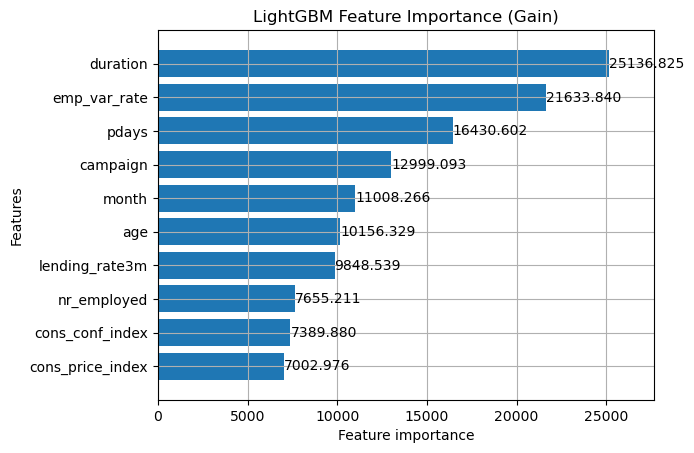

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# 使用 'split', 'gain', 'cover' 作为 importance_type 的不同值
# 'split'：特征被分裂的次数
# 'gain'：特征每次分裂带来的信息增益
# 'cover'：特征分裂时覆盖的样本数

# 可视化 LightGBM 模型的特征重要性
lgb.plot_importance(loaded_model_lgbm, importance_type='gain', max_num_features=10, height=0.8)

# 设置图形标题
plt.title('LightGBM Feature Importance (Gain)')
plt.show()